In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from collections import deque
import shutil
from matplotlib.animation import FFMpegWriter
from IPython.display import HTML

In [2]:
class CelestialBody:
    def __init__(self, name, radius, color, year, parent = None, theta0 = 0):
        # Basic physical/visual attributes of a body.
        # radius: orbital radius (AU); year: orbital period (days)
        # parent: another CelestialBody this body orbits around (None for the root/star)
        # theta0: initial phase (degrees) converted to radians for trig formulas
        self.name = name
        self.radius = radius
        self.color = color
        self.year = year
        self.theta0 = 2*np.pi*theta0/360
        self.parent = parent

    def __str__(self):
        # Human-readable representation used by print()
        return f"CelestialBody(name={self.name}, radius={self.radius}, color={self.color}, year={self.year})"

    def __repr__(self):
        # Fallback for interactive representations (e.g., in lists/dicts)
        return self.__str__()

    def position(self, t):
      # Return absolute position (x, y) in AU at time t (days) in the root frame.
      # The root (parent is None) is fixed at (0, 0).
      if self.parent is None:
        return (0.0, 0.0)
      # Angle advanced since epoch: initial phase + 2π * (elapsed fraction of orbital period)
      theta = self.theta0 + 2*np.pi*(t/self.year)
      # Recursively get parent position at time t (supports chains: moon -> planet -> star)
      px, py = self.parent.position(t)
      # Parametric circle around the parent, then translate by the parent's coordinates
      x = self.radius * np.cos(theta) + px
      y = self.radius * np.sin(theta) + py
      return (x, y)

class SolarSystem:
    def __init__(self, star: CelestialBody):
        # star is the root body (e.g., the Sun). It anchors the absolute frame.
        self.star = star
        # Name of the body used as the default center of the view/frame
        self.center = star.name
        # All bodies indexed by name for easy lookup
        self.bodies = {star.name: star}
        # Adjacency-like mapping: parent_name -> list of child names (optional helper)
        self.orbits = {}

    def set_center(self, name: str):
        # Change the visualization/reference center (e.g., "Earth" for geocentric view)
        if name not in self.bodies:
            raise ValueError(f"Body {name} not in the system!")
        self.center = name

    def add_planet(self, planet: CelestialBody):
        # Attach a planet to the star and register it
        planet.parent = self.star
        self.bodies[planet.name] = planet
        # Ensure a list for the star's children exists, then append
        self.orbits.setdefault(self.star.name, []).append(planet.name)

    def add_moon(self, moon: CelestialBody, planet_name: str):
        # Attach a moon to a specific planet already in the system
        if planet_name not in self.bodies:
            raise ValueError(f"Planet {planet_name} not in the system!")
        moon.parent = self.bodies[planet_name]
        self.bodies[moon.name] = moon
        self.orbits.setdefault(planet_name, []).append(moon.name)

    def summary(self):
        # Quick textual dump for debugging / inspection
        print(f"The solar system centered on: {self.center}")
        for name, body in self.bodies.items():
            print(body)

    def positions(self, t, center_name: str | None = None, lens = None):
        # Compute absolute positions for all bodies at time t (days)
        pos_abs = {name: body.position(t) for name, body in self.bodies.items()}

        # If no center specified, return absolute (heliocentric) coordinates
        if center_name is None:
            return pos_abs

        # Re-center coordinates so that the chosen center sits at (0, 0)
        if center_name not in pos_abs:
            raise ValueError(f"Center '{center_name}' not found in system")
        cx, cy = pos_abs[center_name]
        pos_frame = {name: (x - cx, y - cy) for name, (x, y) in pos_abs.items()}

        # If no lens, return the re-centered coordinates
        if lens is None:
          return pos_frame

        # Otherwise apply the lens transform (nonlinear scaling) to each point
        return {name: lens(np.array([x, y])) for name, (x, y) in pos_frame.items()}

class Lenses:
    def __init__(self, kind="radial_log", s=1.0, r0=1.0):
        # kind: which transform to use ("radial_log", "axis_symlog", "linear")
        # s: global scale factor; r0: 'knee' parameter controlling compression onset
        self.kind = kind
        self.s = s
        self.r0 = r0

    def __call__(self, xy):
        # Make the instance callable like a function: lens((x, y)) -> (x', y')
        v = np.asarray(xy, dtype=float)

        # Radial distance from origin in the current frame
        r = np.linalg.norm(v)
        # Avoid division by zero for radial modes; axis_symlog does not need this
        if r == 0.0 and self.kind != "axis_symlog":
            return v.copy()

        if self.kind == "axis_symlog":
            # Apply a signed log transform independently on axes; preserves quadrants
            return self.s * np.sign(v) * np.log(1 + np.abs(v) / self.r0)

        elif self.kind == "radial_log":
            # Compress distances isotropically as a function of radius only
            rp = self.s * np.log(1 + r / self.r0)   # new radius after compression
            return v * (rp / r)                     # rescale vector to new radius

        elif self.kind == "linear":
            # Simple linear scaling of radius
            rp = self.s * r
            return v * (rp / r)

        else:
            # Safety for invalid kind values
            raise ValueError(f"Unknown lens kind: {self.kind}")


In [3]:
sun = CelestialBody("Sun",
                    radius = None,      # root body: no orbit radius (it's the reference origin)
                    color = "yellow",
                    year = None,        # no orbital period for the root
                    parent = None)      # no parent: (0, 0) in absolute frame

mercury = CelestialBody("Mercury",
                        radius = 0.45,   # orbital radius in AU (simplified here)
                        color = "grey",
                        year = 88,       # orbital period in days
                        parent = sun)    # temporarily set; add_planet() will also set parent

venus = CelestialBody("Venus",
                      radius = 0.72,
                      color = "orange",
                      year = 225,
                      parent = sun)

earth = CelestialBody("Earth",
                      radius = 1.0,
                      color = "blue",
                      year = 365,
                      parent = sun)

moon = CelestialBody("Moon",
                     radius = 0.0026,   # ~ 384,400 km ≈ 0.00257 AU (rounded)
                     color = "lightgray",
                     year = 30,         # simplified synodic month (~29.5 d) rounded to 30
                     parent = earth)    # moon orbits Earth

mars = CelestialBody("Mars",
                     radius = 1.52,
                     color = "red",
                     year = 687,
                     parent = sun)

jupiter = CelestialBody("Jupiter",
                        radius = 5.21,
                        color = "brown",
                        year = 4333,
                        parent = sun)

saturn = CelestialBody("Saturn",
                       radius = 9.6,
                       color = "pink",
                       year = 10759,
                       parent = sun)

uranus = CelestialBody("Uranus",
                       radius = 19.2,
                       color = "cyan",
                       year = 30687)
                       # parent not passed → defaults to None here; will be set in add_planet()

neptune = CelestialBody("Neptune",
                        radius = 30.2,
                        color = "purple",
                        year = 60190)
                        # parent not passed → defaults to None here; will be set in add_planet()

system = SolarSystem(sun)            # initialize the system with Sun as the root body
system.add_planet(mercury)           # registers body and ensures parent = star
system.add_planet(venus)
system.add_planet(earth)
system.add_planet(mars)
system.add_planet(jupiter)
system.add_planet(saturn)
system.add_planet(uranus)            # parent gets set to Sun here
system.add_planet(neptune)           # parent gets set to Sun here
system.add_moon(moon, "Earth")       # attach Moon under Earth

system.summary()                     # print a summary: current center + all bodies

The solar system centered on: Sun
CelestialBody(name=Sun, radius=None, color=yellow, year=None)
CelestialBody(name=Mercury, radius=0.45, color=grey, year=88)
CelestialBody(name=Venus, radius=0.72, color=orange, year=225)
CelestialBody(name=Earth, radius=1.0, color=blue, year=365)
CelestialBody(name=Mars, radius=1.52, color=red, year=687)
CelestialBody(name=Jupiter, radius=5.21, color=brown, year=4333)
CelestialBody(name=Saturn, radius=9.6, color=pink, year=10759)
CelestialBody(name=Uranus, radius=19.2, color=cyan, year=30687)
CelestialBody(name=Neptune, radius=30.2, color=purple, year=60190)
CelestialBody(name=Moon, radius=0.0026, color=lightgray, year=30)


In [4]:
YEARS = 165
SAMPLES = 10000
t_days = np.linspace(0.0, YEARS * 365, SAMPLES)  # time samples in days across the chosen horizon

USE_LENS = True
lens = Lenses(kind="radial_log", s=1.0, r0=1) if USE_LENS else None  # optional nonlinear distance compression

def render_orbits_snapshot(system, center_name, t_days, end, lens=None, figsize=(8,8)):
    """
    Draw a static snapshot of orbital paths in a chosen reference frame.

    Args:
        system: SolarSystem instance with registered bodies.
        center_name: name of the body that defines the frame center (its position becomes (0,0)).
        t_days: 1D array of time samples (days) used to trace paths.
        end: dict{name -> int} telling how many leading samples to keep for each body;
             this lets you truncate paths per-body to avoid overdraw/dark bands.
        lens: optional Lenses() callable; if given, positions are transformed before plotting.
        figsize: Matplotlib figure size.

    Notes:
        - Paths are sampled once at all times into pre_traces, then per-body truncated into traces
          using 'end[name]'. This avoids plotting full N samples when you only want the first k.
        - pre_traces and traces store tuples of two *lists* (xs, ys). Tuples are immutable,
          but the lists inside are mutable (we append/extend them).
    """

    names = [n for n in system.bodies.keys()]                 # stable iteration order
    pre_traces = {n: ([], []) for n in names}                 # raw full-length paths
    traces     = {n: ([], []) for n in names}                 # truncated paths to actually plot

    # Sample positions for all bodies across all time samples in the chosen frame + lens.
    for td in t_days:
        pos = system.positions(td, center_name=center_name, lens=lens)
        for n in names:
            x, y = pos[n]
            pre_traces[n][0].append(x)                        # append x_t
            pre_traces[n][1].append(y)                        # append y_t

    # Truncate each body's path to the desired length end[n]
    # (guard with min(...) so user can't exceed available samples)
    for n in names:
        k = min(end.get(n, len(pre_traces[n][0])), len(pre_traces[n][0]))
        traces[n][0].extend(pre_traces[n][0][:k])             # keep first k xs
        traces[n][1].extend(pre_traces[n][1][:k])             # keep first k ys

    # Figure and axis setup
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect("equal", "box")

    # Autoscale axes based on all truncated traces; add a small symmetric padding
    all_x = np.concatenate([np.array(traces[n][0]) for n in names]) if names else np.array([])
    all_y = np.concatenate([np.array(traces[n][1]) for n in names]) if names else np.array([])
    if all_x.size > 0:
        mx = max(np.max(np.abs(all_x)), np.max(np.abs(all_y)))
        pad = 0.05 * mx if mx > 0 else 1.0
        ax.set_xlim(-mx - pad, mx + pad)
        ax.set_ylim(-mx - pad, mx + pad)
    else:
        # Fallback bounds when there are no points to show
        ax.set_xlim(-1, 1); ax.set_ylim(-1, 1)

    # Draw each body's path as a thin line (except the chosen center), plus a dot at the last point
    for n in names:
        body = system.bodies[n]
        xs, ys = traces[n]
        lw = 0.0 if n == center_name else 0.5                 # do not draw a path for the frame center
        if lw > 0 and len(xs) > 1:
            ax.plot(xs, ys, lw=lw, alpha=0.8, color=body.color, label=n)
        if len(xs) > 0:
            ax.scatter([xs[-1]], [ys[-1]],                    # last sampled position as a marker
                       s=(20 if n != "Moon" else 12),
                       color=body.color)

    # Title/legend and clean look (no grid/axes)
    title = f"Orbits over {YEARS} years | center = {center_name}"
    if lens is not None:
        title += f" | lens={lens.kind}"
    ax.set_title(title)
    ax.legend(fontsize=8, ncol=2, loc="upper right")
    ax.grid(False)
    ax.axis("off")

    plt.show()


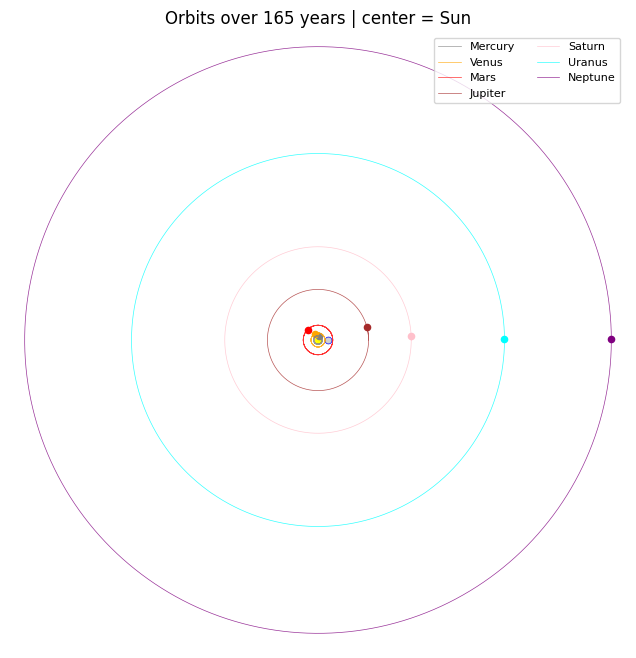

In [5]:
USE_LENS = False
lens = Lenses(kind="radial_log", s=1.0, r0=1) if USE_LENS else None

end = {'Sun': 65,
       'Mercury': 150,
       'Venus': 200,
       'Earth': 1,
       'Mars': 500,
       'Jupiter': 750,
       'Saturn': 1800,
       'Uranus': 5100,
       'Neptune': 10000,
       'Moon': 1}

render_orbits_snapshot(system, "Sun", t_days, end, lens=lens, figsize=(8,8))

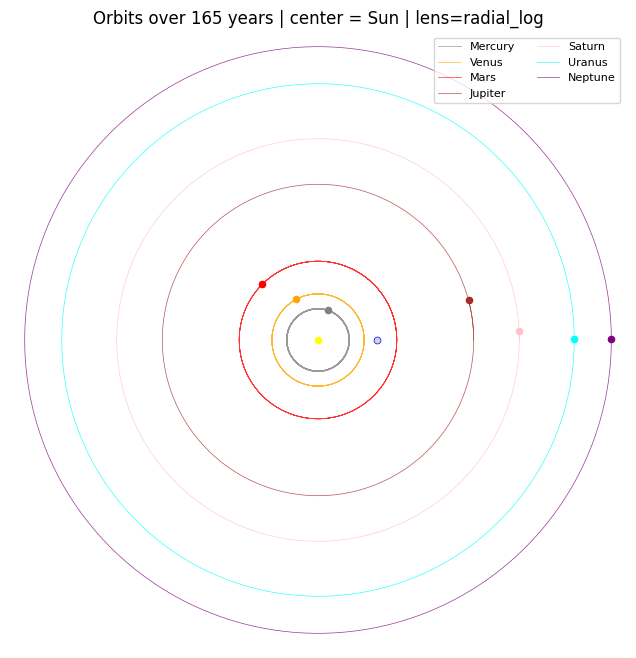

In [6]:
USE_LENS = True
lens = Lenses(kind="radial_log", s=1.0, r0=1) if USE_LENS else None

end = {'Sun': 65,
       'Mercury': 150,
       'Venus': 200,
       'Earth': 1,
       'Mars': 500,
       'Jupiter': 750,
       'Saturn': 1800,
       'Uranus': 5100,
       'Neptune': 10000,
       'Moon': 1}

render_orbits_snapshot(system, "Sun", t_days, end, lens=lens, figsize=(8,8))

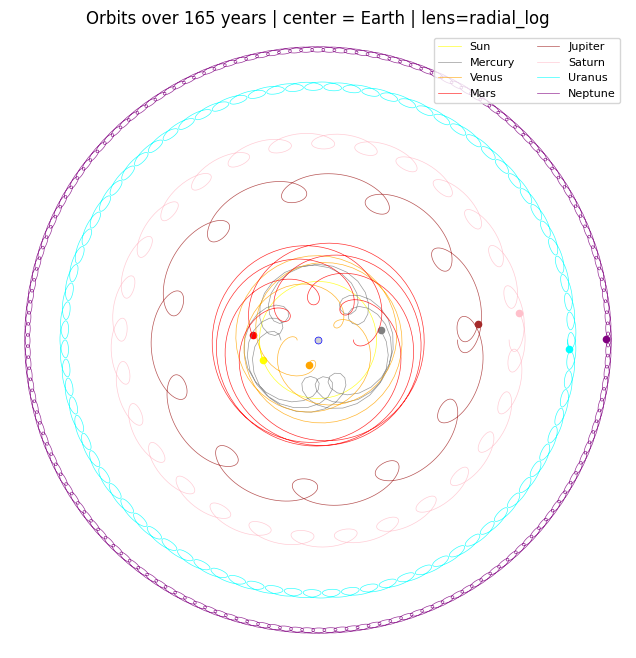

In [7]:
USE_LENS = True
lens = Lenses(kind="radial_log", s=1.0, r0=1) if USE_LENS else None

end = {'Sun': 65,
       'Mercury': 150,
       'Venus': 200,
       'Earth': 1,
       'Mars': 500,
       'Jupiter': 750,
       'Saturn': 1800,
       'Uranus': 5100,
       'Neptune': 10000,
       'Moon': 1}

render_orbits_snapshot(system, "Earth", t_days, end, lens=lens, figsize=(8,8))

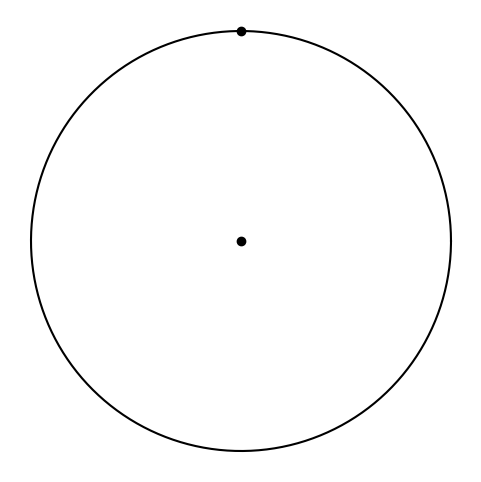

In [8]:
r = 1
center = (0, 0)
walker = (0, 1)

theta = np.linspace(0, 2 * np.pi, 500)
x = center[0] + r * np.cos(theta)
y = center[1] + r * np.sin(theta)

plt.figure(figsize=(6, 6))
plt.plot(x, y, label="Circle", color="black")
plt.scatter(*center, color="black", zorder=5, label="Center")
plt.scatter(*walker, color="black", zorder=5, label="Center")
plt.gca().set_aspect("equal", adjustable="box")
plt.grid(False)
plt.axis("off")
plt.show()

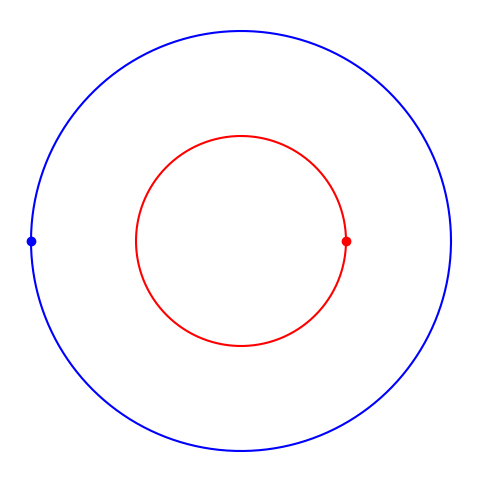

In [9]:
radii = [1, 2]
colors = ["red", "blue"]
center = (0, 0)

theta = np.linspace(0, 2 * np.pi, 500)

plt.figure(figsize=(6, 6))

for r, c in zip(radii, colors):
    x = center[0] + r * np.cos(theta)
    y = center[1] + r * np.sin(theta)
    plt.plot(x, y, color=c, label=f"Circle radius {r}")

plt.scatter(1, 0, color="red", zorder=5, label="Point (1,0)")
plt.scatter(-2, 0, color="blue", zorder=5, label="Point (2,0)")

plt.gca().set_aspect("equal", adjustable="box")
plt.grid(False)
plt.axis("off")
plt.show()


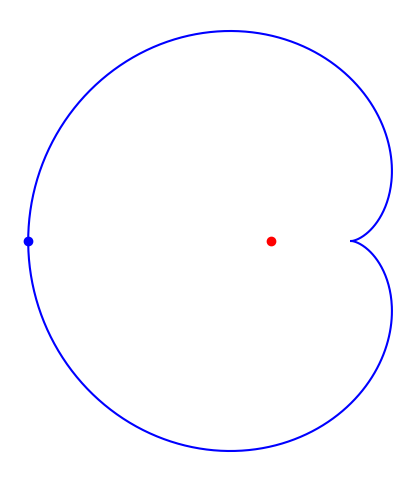

In [10]:
radii = [1, 2]
colors = ["red", "blue"]
center = (0, 0)

theta = np.linspace(0, 2 * np.pi, 500)

plt.figure(figsize=(6, 6))

x = 2 * np.cos(theta) - center[0] - np.cos(2*theta)
y = 2 * np.sin(theta) - center[1] - np.sin(2*theta)

plt.plot(x, y, color=c, label=f"Circle radius {r}")

plt.scatter(0, 0, color="red", zorder=5, label="Point (1,0)")
plt.scatter(-3, 0, color="blue", zorder=5, label="Point (2,0)")

plt.gca().set_aspect("equal", adjustable="box")
plt.grid(False)
plt.axis("off")
plt.show()
